### Tutorial 3
## Evaluating and testing

In this Notebook, we show how to evaluate a learned forward operator on data. We do this by incorporating the learned forward operator into a iterative scheme for solving the variational CT reconstruction problem, and comparing the images to those generated by the full physics model, as well as the approximate forward operator on which the learned one is based. In this work, we use the BFGS algorithm for reconstruction.  

In [3]:
# Import Session
from learned_reconstruction.learning_session import *
from learned_reconstruction.operator_modules import *
#from learned_reconstruction.plots import *
from tools.plots import *
from tools.logger import EventTracker
import matplotlib.pyplot as plt
import torch
import os

# Choose device to run training and testing on.
device = "cuda"

# Session directory
ses_path = "sessions/session_kits/"

# Directory for quick loading into working memory
data_path = "data/ct_session_data/"

First, load an old training session, and pick a save state by setting `epoch` to some number where save data exists (If you don't know, look in the session folder). If `epoch` is set to `None`, the most recent checkpoint is loaded.

In [4]:
ses = FwdBwdSession.load_old_session(name = "session_2021_03_28", epoch=None, path=ses_path, save_every_n=100)

Picking most recent save: 511
Directory already exists! Loading session ...
Creating operators...


/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Creating corrective nets...
Preparing data ...
Found 80 data points. Returning data object.
Loading closest checkpoint, 511
Done loading states.
Done loading states.


Next, we define three different gradients, corresponding to the variational loss function with an accurate forward operator, approximate forward operator and learned forward operator. 

In [6]:
ses.eval_mode()
torch.cuda.empty_cache()

x = torch.load("sessions/session_kits/data_test/phantom_test_0.Tensor").to("cuda")
y = torch.poisson(ses.fwd_acc(x))

grad_acc = lambda x: ses.loss_gradient(x, ses.fwd_acc, ses.bwd_acc, y)
grad_apx = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
def grad_cor(x):
    with torch.no_grad():
        ret = ses.loss_gradient(x, ses.fwd_correction, ses.bwd_correction, y)
    return ret
    
methods = {"name": ["Accurate", "Approximate", "Learned"], 
           "grad": [grad_acc, grad_apx, grad_cor], 
           "loss": [[], [], []], 
           "reconstruction": []}

Then, initialise noisy reconstructions by iterating with the approximate gradient, and generate reconstructions using the three different gradients, using the noisy reconstructions as initial guesses. This reduces the iterations needed for convergence with the more expensive methods.

In [ ]:
# First, iterate 4000 steps with approximate
x_init, _, _= ses.bfgs_steps(x, grad_apx, ses.phantom_inner, step=1.0, iter=4000, num_store=10, verbose=True)

# Then, iterate with each separate for N=2000 steps
N = 4000
for i in [0,1,2]:
    g = methods["grad"][i]
    name = methods["name"][i]
    loss = methods["loss"][i]
    
    class Callback():
        def __init__(self):
            self.counter = 0
            
        def __call__(self, x, i, ss, ys):
            if self.counter % 10 == 0:
                loss.append(ss[-1].norm().item())
                print(f"{name}, iteration {self.counter}/{N}, loss={loss[-1]:.4E}", end="\r")
                
            self.counter += 1
      
    x, _, _ = ses.bfgs_steps(x_init, g, ses.phantom_inner, step=1.0, iter=N, num_store=10, callback=Callback())
    torch.save(x, ses.session_path + f"/output_img/recon_{name}.Tensor")
torch.save(methods, ses.session_path + f"/output_img/losses_")

To plot the reconstructions, use `plot_image_channels()`. It takes the following arguments:
* `images` list containing cpu-side tensors or np.array objects with three non-singleton dimensions. The first dimension is interpreted as a channel, and the other two as a pixel grid. The shape of the images should be the same.
* `image_labels` list of strings labling the objects in `images`.
* `channel_labels` list of labels for the channels of an object in `images`.
* `spyglass_coords` list of coordinate points to zoom in on. 
* `subset` a subset of indices representing a subset of the available image channels.
* `colorbar` boolean. whether or not to include a colorbar.
* `**kwargs` arguments to feed `plt.imshow()` together with each object in `images`. 

First, load and plot the reconstrutions.

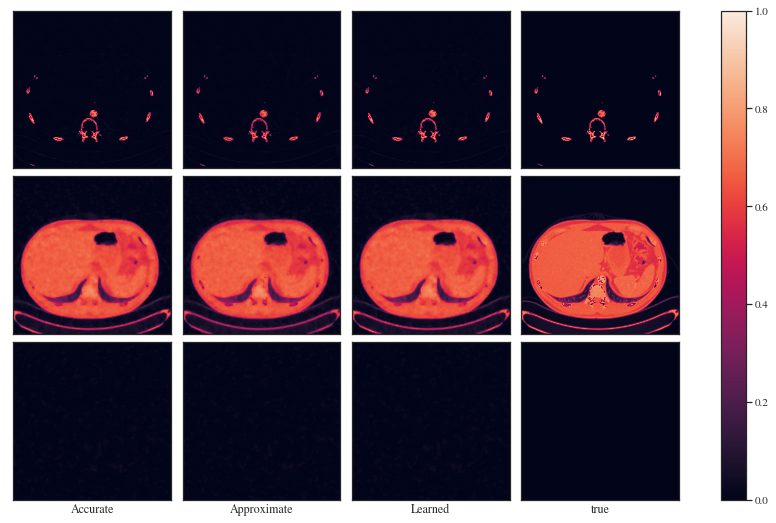

In [15]:
recs = [torch.load(ses.session_path + f"/output_img/recon_{name}.Tensor") for name in methods["name"]]
recs = [r.cpu().detach().numpy() for r in recs]
x = torch.load("sessions/session_kits/data_test/phantom_test_0.Tensor").detach().to("cpu").numpy()
recs.append(x)
labels = methods["name"] + ["true"]
    
#help(plot_image_channels)
_= plot_image_channels(images=recs,
                    image_labels=labels,
                    channel_labels=None,
                    spyglass_coords=None,
                    spyglass_color="white",
                    colorbar=False,
                    subset=None,
                    scale=3,
                    vmin=0, 
                    vmax=1)


Next, plot the approximation errors, |Accurate - Approximate| and |Accurate - Learned|. We note that the learned forward operator shows a significantly lower approximation error, although it might not be easily visible when comparing the reconstructions themselves as above.

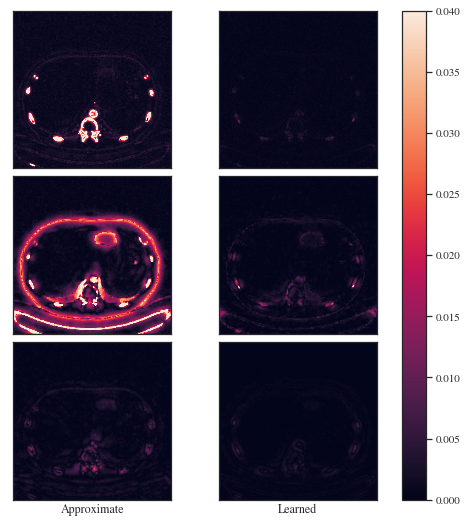

In [19]:
_=plot_image_channels([np.abs(r - recs[0]) for r in recs[1:-1]], 
                   image_labels=labels[1:-1],
                   scale=3,vmin=0, vmax=0.04)

Lastly, plot the reconstruction error, i.e. difference from ground truth. Looking closely, there are slight variations in reconstruction error between the accurate and approximate forward operators.

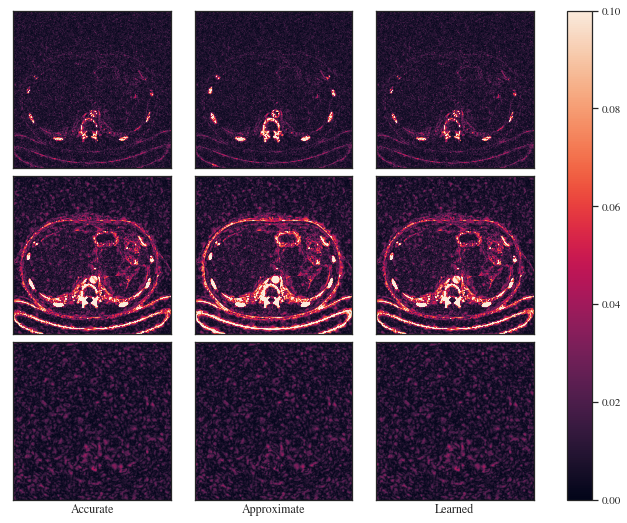

In [29]:
_=plot_image_channels([np.abs(r - recs[-1]) for r in recs[0:-1]], 
                      image_labels=labels[0:-1],
                      scale=3,
                      vmin=0, 
                      vmax=0.1)

The tables reported in [1] were obtained by repeating the reconstruction procedure multiple times with different data points, and averaging out quality of fit metrics on the results.